# **Transformer**

In [18]:
import tweepy
import time
import pandas as pd
import numpy as np
import yfinance as yf
import re
import datetime
from datetime import timezone
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, Conv1D 

from google.colab import drive, files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


We generate data thanks to yahoo finance

In [19]:
def generate_data(ticker, start_date, end_date, rollingAvg=10, window = 30):
  stock_data = yf.download(stock_ticker, interval = "1d", start=str(start_date), end=str(end_date)).drop(columns=['Adj Close'])
  stock_data[['Open', 'High', 'Low', 'Close', 'Volume']] = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(rollingAvg).mean()
  stock_data['Open'] = stock_data['Open'].pct_change()
  stock_data['High'] = stock_data['High'].pct_change()
  stock_data['Low'] = stock_data['Low'].pct_change()
  stock_data['Close'] = stock_data['Close'].pct_change()
  stock_data['Volume'] = stock_data['Volume'].pct_change()
  stock_data.dropna(how='any', axis=0, inplace=True)

  train_indexes = int(0.8*len(stock_data))
  val_indexes = int(0.1*len(stock_data))

  train_data = stock_data.iloc[:train_indexes, :]

  # minRet = train_data[['Open', 'High', 'Low', 'Close']].min(axis=0).min(axis=0)
  minRet = min(train_data[['Open', 'High', 'Low', 'Close']].min(axis=0))
  # maxRet = train_data[['Open', 'High', 'Low', 'Close']].max(axis=0).max(axis=0)
  maxRet = max(train_data[['Open', 'High', 'Low', 'Close']].max(axis=0))

  stock_data['Open'] = (stock_data['Open'] - minRet) / (maxRet - minRet)
  stock_data['High'] = (stock_data['High'] - minRet) / (maxRet - minRet)
  stock_data['Low'] = (stock_data['Low'] - minRet) / (maxRet - minRet)
  stock_data['Close'] = (stock_data['Close'] - minRet) / (maxRet - minRet)

  minVolume = min(train_data[['Volume']].min(axis=0))
  maxVolume = max(train_data[['Volume']].max(axis=0))

  stock_data['Volume'] = (stock_data['Volume'] - minVolume) / (maxVolume - minVolume)

  train_data = stock_data.iloc[:train_indexes, :]
  val_data = stock_data.iloc[train_indexes:train_indexes+val_indexes, :]
  test_data = stock_data.iloc[train_indexes+val_indexes:, :]

  X_train,y_train = [], []
  for i in range(window, len(train_data)):
    X_train.append(train_data.values[i-window:i])
    y_train.append(train_data.values[:, 3][i])
  X_train, y_train = np.array(X_train), np.array(y_train)

  X_val, y_val = [], []
  for i in range(window, len(val_data)):
      X_val.append(val_data.values[i-window:i])
      y_val.append(val_data.values[:, 3][i])
  X_val, y_val = np.array(X_val), np.array(y_val)

  X_test, y_test = [], []
  for i in range(window, len(test_data)):
      X_test.append(test_data.values[i-window:i])
      y_test.append(test_data.values[:, 3][i])    
  X_test, y_test = np.array(X_test), np.array(y_test)

  return X_train, y_train, X_val, y_val, X_test, y_test, minRet, maxRet

In [20]:
def generate_linear_data(ticker, start_date, end_date, rollingAvg=10, window = 30):
  stock_data = yf.download(ticker, interval = "1d", start=str(start_date), end=str(end_date)).drop(columns=['Adj Close'])
  stock_data[['Open', 'High', 'Low', 'Close', 'Volume']] = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(rollingAvg).mean()
  stock_data['Open'] = stock_data['Open'].pct_change()
  stock_data['High'] = stock_data['High'].pct_change()
  stock_data['Low'] = stock_data['Low'].pct_change()
  stock_data['Close'] = stock_data['Close'].pct_change()
  stock_data['Volume'] = stock_data['Volume'].pct_change()
  stock_data.dropna(how='any', axis=0, inplace=True)

  train_indexes = int(0.8*len(stock_data))
  val_indexes = int(0.1*len(stock_data))

  train_data = stock_data.iloc[:train_indexes, :]

  # minRet = train_data[['Open', 'High', 'Low', 'Close']].min(axis=0).min(axis=0)
  minRet = min(train_data[['Open', 'High', 'Low', 'Close']].min(axis=0))
  # maxRet = train_data[['Open', 'High', 'Low', 'Close']].max(axis=0).max(axis=0)
  maxRet = max(train_data[['Open', 'High', 'Low', 'Close']].max(axis=0))

  stock_data['Open'] = (stock_data['Open'] - minRet) / (maxRet - minRet)
  stock_data['High'] = (stock_data['High'] - minRet) / (maxRet - minRet)
  stock_data['Low'] = (stock_data['Low'] - minRet) / (maxRet - minRet)
  stock_data['Close'] = (stock_data['Close'] - minRet) / (maxRet - minRet)

  minVolume = min(train_data[['Volume']].min(axis=0))
  maxVolume = max(train_data[['Volume']].max(axis=0))

  stock_data['Volume'] = (stock_data['Volume'] - minVolume) / (maxVolume - minVolume)

  train_data = stock_data.iloc[:train_indexes, :]
  val_data = stock_data.iloc[train_indexes:train_indexes+val_indexes, :]
  test_data = stock_data.iloc[train_indexes+val_indexes:, :]

  X_train,y_train = [], []
  for i in range(window, len(train_data)):
    X_train.append(train_data.values[i-window:i].flatten())
    y_train.append(train_data.values[:, 3][i])
  X_train, y_train = np.array(X_train), np.array(y_train)

  X_val, y_val = [], []
  for i in range(window, len(val_data)):
      X_val.append(val_data.values[i-window:i].flatten())
      y_val.append(val_data.values[:, 3][i])
  X_val, y_val = np.array(X_val), np.array(y_val)

  X_test, y_test = [], []
  for i in range(window, len(test_data)):
      X_test.append(test_data.values[i-window:i].flatten())
      y_test.append(test_data.values[:, 3][i])    
  X_test, y_test = np.array(X_test), np.array(y_test)

  return X_train, y_train, X_val, y_val, X_test, y_test, minRet, maxRet

##Linear regression

We implement our first baseline model : the linear regression

[*********************100%***********************]  1 of 1 completed
0.0019129561599127134
0.0020330053597472147


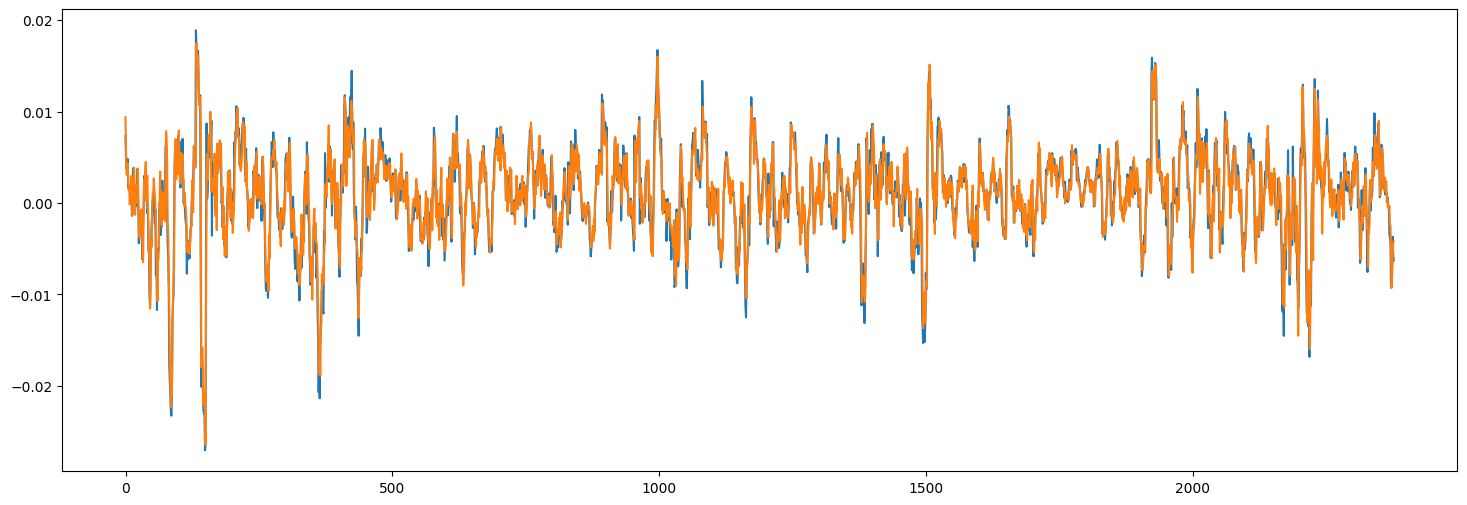

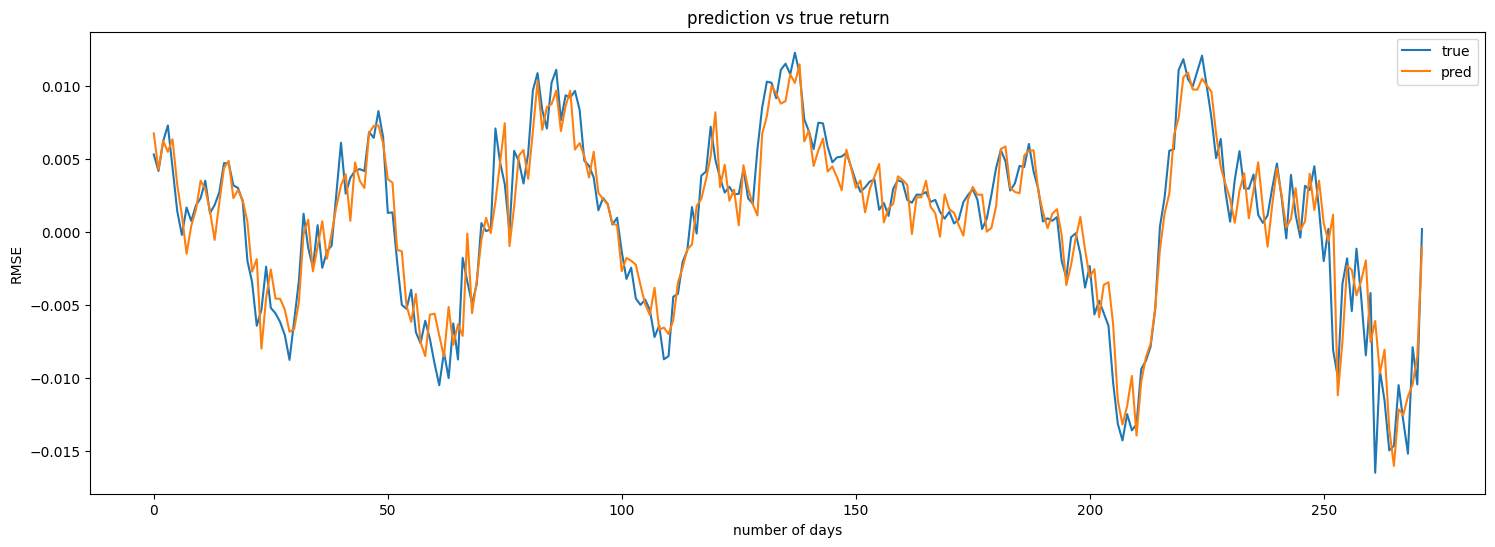

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

start_date = "2010-01-01"
end_date =  "2022-01-01"

X_train, y_train, X_val, y_val, X_test, y_test, minRet, maxRet = generate_linear_data('ADBE', start_date = start_date, end_date = end_date, window = 30)
m = LinearRegression() 
m.fit(X_train, y_train)
y_test_pred = m.predict(X_test)
y_train_pred = m.predict(X_train)
y_test = y_test*(maxRet - minRet) + minRet
y_train = y_train*(maxRet - minRet) + minRet
y_test_pred = y_test_pred*(maxRet - minRet) + minRet
y_train_pred = y_train_pred*(maxRet - minRet) + minRet
fig, ax = plt.subplots(figsize = (18, 6))
ax.plot(y_train)
ax.plot(y_train_pred)
print(mse(y_train_pred, y_train, squared = False))
fig,ax = plt.subplots(figsize = (18, 6))
ax.plot(y_test, label='true')
ax.plot(y_test_pred, label='pred')
ax.legend()
ax.set_xlabel('number of days')
ax.set_ylabel('RMSE')
ax.set_title('prediction vs true return')
print(mse(y_test_pred, y_test, squared = False))

We plot some metrics  : QQ plot and error density plot

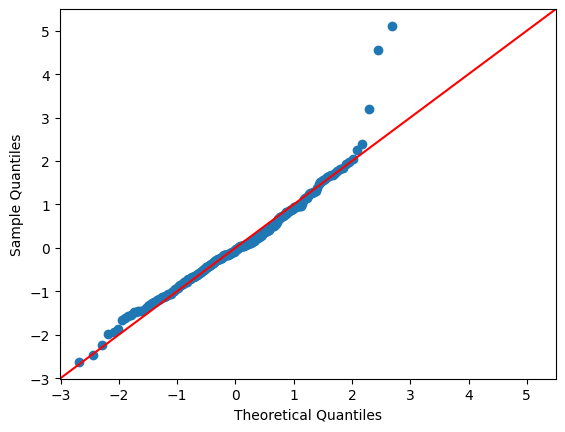

In [22]:
import statsmodels.api as sm
fig = sm.qqplot((np.array(y_test_pred) - np.array(y_test))/np.std(np.array(y_test_pred) - np.array(y_test)), line='45')
plt.show()

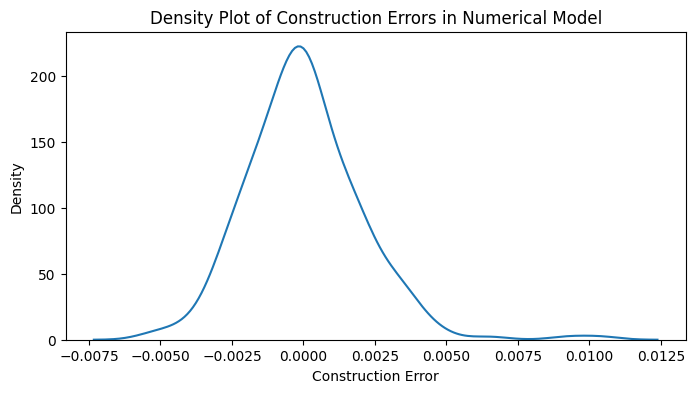

Mean of Construction Errors: 2.4636711329640907e-05
Standard Deviation of Construction Errors: 0.0020328560758734893


In [23]:
errors  = (np.array(y_test_pred) - np.array(y_test))

import seaborn as sns
# Calculate the construction errors
plt.figure(figsize=(8, 4))
sns.kdeplot(errors, bw_adjust=1)
plt.xlabel("Construction Error")
plt.ylabel("Density")
plt.title("Density Plot of Construction Errors in Numerical Model")
plt.show()


mean_error = np.mean(errors)
std_error = np.std(errors)

print("Mean of Construction Errors:", mean_error)
print("Standard Deviation of Construction Errors:", std_error)

We then plot the training/testing rmse with the rolling window 

window :  10
[*********************100%***********************]  1 of 1 completed
window :  11
[*********************100%***********************]  1 of 1 completed
window :  12
[*********************100%***********************]  1 of 1 completed
window :  13
[*********************100%***********************]  1 of 1 completed
window :  14
[*********************100%***********************]  1 of 1 completed
window :  15
[*********************100%***********************]  1 of 1 completed
window :  16
[*********************100%***********************]  1 of 1 completed
window :  17
[*********************100%***********************]  1 of 1 completed
window :  18
[*********************100%***********************]  1 of 1 completed
window :  19
[*********************100%***********************]  1 of 1 completed
window :  20
[*********************100%***********************]  1 of 1 completed
window :  21
[*********************100%***********************]  1 of 1 completed
window :  22
[**

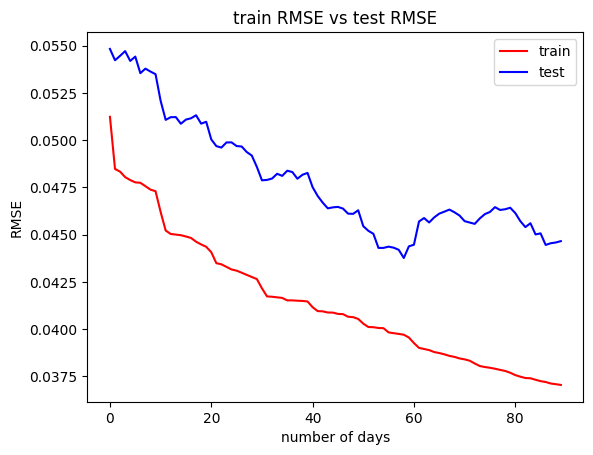

In [24]:
start_date = "2010-01-01"
end_date =  "2022-01-01"

windows = []
test_rmse = []
train_rmse = []
test_r2 = []
train_r2 = []

for i in range(10, 100):
  windows.append(i)
  print('window : ', i)
  X_train, y_train, X_val, y_val, X_test, y_test, minRet, maxRet = generate_linear_data('AAPL', start_date = start_date, end_date = end_date, window = i)
  m = LinearRegression()
  m.fit(X_train, y_train)
  y_train_pred = m.predict(X_train)
  train_rmse.append(mse(y_train_pred, y_train, squared = False))
  y_test_pred = m.predict(X_test)
  test_rmse.append(mse(y_test_pred, y_test, squared = False))

plt.plot(train_rmse, color='r', label='train')
plt.plot(test_rmse, color='b', label='test')
plt.legend()
plt.xlabel('number of days')
plt.ylabel('RMSE')
plt.title('train RMSE vs test RMSE')
plt.show()



## Transformer Layers

In [25]:
# class Time2Vec(Layer):
#   def __init__(self, seq_len, **kwargs):
#     super(Time2Vec, self).__init__()
#     self.seq_len = seq_len

#   def build(self, input_shape):
#     '''Initialize weights and biases with shape (batch, seq_len)'''
#     self.weights_linear = self.add_weight(name='weight_linear',
#                                 shape=(int(self.seq_len),),
#                                 initializer='uniform',
#                                 trainable=True)
    
#     self.bias_linear = self.add_weight(name='bias_linear',
#                                 shape=(int(self.seq_len),),
#                                 initializer='uniform',
#                                 trainable=True)
    
#     self.weights_periodic = self.add_weight(name='weight_periodic',
#                                 shape=(int(self.seq_len),),
#                                 initializer='uniform',
#                                 trainable=True)

#     self.bias_periodic = self.add_weight(name='bias_periodic',
#                                 shape=(int(self.seq_len),),
#                                 initializer='uniform',
#                                 trainable=True)

#   def call(self, x):
#     '''Calculate linear and periodic time features'''
#     x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
#     time_linear = self.weights_linear * x + self.bias_linear 
#     time_linear = tf.expand_dims(time_linear, axis=-1) 
    
#     time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
#     time_periodic = tf.expand_dims(time_periodic, axis=-1) 
#     return tf.concat([time_linear, time_periodic], axis=-1)
   
#   def get_config(self): 
#     config = super().get_config().copy()
#     config.update({'seq_len': self.seq_len})
#     return config

In [26]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear 
    time_linear = tf.expand_dims(time_linear, axis=-1) 
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) 
    return tf.concat([time_linear, time_periodic], axis=-1)
   
  def get_config(self): 
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [56]:
class SingleAttention2(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention2, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention2(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

class TransformerMultiHeadEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerMultiHeadEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          
     

In [28]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.attention = Attention(use_scale=True)
    
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])
    
    v = self.value(inputs[2])
    attn_out = self.attention([q, k, v])
    return attn_out  


class CausalAttention(Layer):
  def __init__(self, d_k, d_v):
    super(CausalAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.linear = Dense(input_shape[-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    q = self.query(inputs)
    k = self.key(inputs)

    causal_mask = tf.linalg.band_part(tf.ones((tf.shape(inputs)[1], tf.shape(inputs)[1])), -1, 0)
    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.multiply(attn_weights, causal_mask)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)

    v = self.value(inputs[2])

    attn_out = tf.matmul(attn_weights, v)
    attn_out = self.linear(attn_out)
    return attn_out    

class TransformerEncoderCausal(Layer):
  def __init__(self, d_k, d_v, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoderCausal, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.ff_dim = ff_dim
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn = CausalAttention(self.d_k, self.d_v)
    self.attn_dropout = Dropout(self.dropout_rate)

    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    self.ff_conv1D_2 = Conv1D(filters=input_shape[-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs):
    attn_layer = self.attn(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs + ff_layer)
    return ff_layer 

  def get_config(self):
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'ff_dim': self.ff_dim,
                   'dropout_rate': self.dropout_rate})
    return config
         


##Models

Multi-Head

In [29]:
def multihead_model(n_num, window_size = 30, num_heads=12, num_layers=3, d_k=256, d_v=256, ff_dim=256, dropout_rate=0.1, lr=0.001):
    inputs = tf.keras.layers.Input(shape=(window_size,n_num))
    time2vec = Time2Vector(window_size)(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([inputs,time2vec])

    for i in range(num_layers):
        x = TransformerMultiHeadEncoder(d_k, d_v, num_heads, ff_dim)((x,x,x))

    x = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_first')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(units=64, activation='relu')(x)
    
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(1, activation="linear")(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['mae'])
    return model

Causal masking

In [30]:
def causal_model(n_num, window_size=30, num_heads=12, num_layers=3, d_k=256, d_v=256, ff_dim=256, dropout_rate=0.1, lr=0.001,**kwargs):
    inputs = tf.keras.layers.Input(shape=(window_size, n_num))
    time2vec = Time2Vector(window_size)(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([inputs, time2vec])
    # Causal masking
    seq_len = window_size
    idxs = np.arange(seq_len)
    mask = idxs[None, :] <= idxs[:, None]    
    mask = tf.expand_dims(tf.expand_dims(mask, axis=0), axis=0)
    #print(mask.shape)
    
    for i in range(num_layers):
        x = TransformerEncoderCausal(d_k, d_v, ff_dim, dropout_rate, causal=True, mask=mask)(x)
    # print(x.shape)
    x = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_first')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(units=64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(1, activation="linear")(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['mae', 'mape'])
    
    return model

In [31]:
pip install np_config

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.4/142.4 kB 3.6 MB/s eta 0:00:00


In [32]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


In [33]:
prediction_stocks = {}
stock_tickers = ['^GSPC', 'AAPL', 'MSFT', 'GOOG', 'META', 'AMZN', 'BAC', 'BRK', 'MA', 'UNH', 'XOM', 'ADBE', 'TFC', 'QCOM', 'NVDA', 'DIS', 'BA', 'CMCSA', 'AMGN', 'TMO', 'NEE']
stock_tickers = ['ADBE']

In [ ]:
import matplotlib.pyplot as plt
start_date = "2010-01-01"
end_date =  "2022-01-01"
window = 30
for stock_ticker in stock_tickers:
  print(stock_ticker)
  X_train, y_train, X_val, y_val, X_test, y_test, minRet, maxRet = generate_data(stock_ticker, start_date, end_date)

  stock_model = multihead_model(X_train.shape[-1], window_size=30, num_heads=12, num_layers=3, d_k=256, d_v=256, ff_dim=256, dropout_rate=0.1, lr=0.001)

  # Add causality mask to the Multi-Head Attention layer

  callback = tf.keras.callbacks.ModelCheckpoint(f'/content/gdrive/MyDrive/DataMiningProject/models/{stock_ticker}-model.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
  history = stock_model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[callback], validation_data=(X_val, y_val))
  
  predictions = stock_model.predict(X_test)*(maxRet - minRet) + minRet
  y_test_transform = y_test*(maxRet - minRet) + minRet
  prediction_stocks[stock_ticker] = [predictions, y_test_transform]

  fig, ax = plt.subplots(figsize = (18,6))
  ax.plot(y_test_transform, label = "Actual")
  ax.plot(predictions, label = "Predictions")
  ax.set_title(f'{stock_ticker} Closing Returns', fontsize=18)
  ax.set_xlabel('Date')
  ax.set_ylabel(f'{stock_ticker} Closing Returns')
  ax.legend(loc="best", fontsize=12)
  fig.savefig(f'/content/gdrive/MyDrive/DataMiningProject/plots/{stock_ticker}-plot.png')


ADBE
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
75/75 [==============================] - 66s 229ms/step - loss: 0.0951 - mae: 0.2261 - mape: 38.0981 - val_loss: 0.0159 - val_mae: 0.0993 - val_mape: 17.8765
Epoch 2/20
75/75 [==============================] - 9s 121ms/step - loss: 0.0139 - mae: 0.0906 - mape: 17.3642 - val_loss: 0.0162 - val_mae: 0.1014 - val_mape: 17.9408
Epoch 3/20
75/75 [==============================] - 7s 96ms/step - loss: 0.0133 - mae: 0.0876 - mape: 16.9730 - val_loss: 0.0151 - val_mae: 0.0951 - val_mape: 17.4420
Epoch 4/20
75/75 [==============================] - 5s 66ms/step - loss: 0.0130 - mae: 0.0868 - mape: 16.8552 - val_loss: 0.0144 - val_mae: 0.0907 - val_mape: 17.0558
Epoch 5/20
75/75 [==============================] - 6s 80ms/step - loss: 0.0131 - mae: 0.0864 - mape: 16.8179 - val_loss: 0.0168 - val_mae: 0.1049 - val_mape: 18.1541
Epoch 6/20
75/75 [==============================] - 6s 79ms/step - loss: 0.0118 - mae: 0

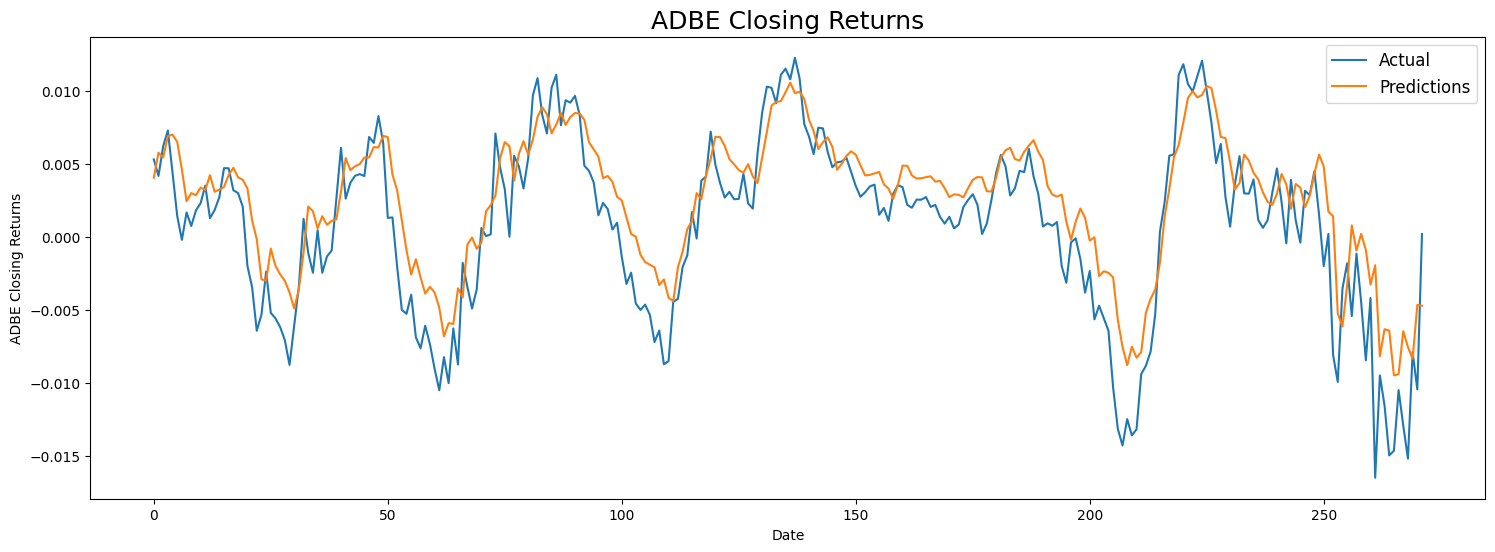

In [34]:
import matplotlib.pyplot as plt
start_date = "2010-01-01"
end_date =  "2022-01-01"
window = 30
for stock_ticker in stock_tickers:
  print(stock_ticker)
  X_train, y_train, X_val, y_val, X_test, y_test, minRet, maxRet = generate_data(stock_ticker, start_date, end_date)

  stock_model = causal_model(X_train.shape[-1], window_size=30, num_heads=12, num_layers=3, d_k=256, d_v=256, ff_dim=256, dropout_rate=0.1, lr=0.001)

  # Add causality mask to the Multi-Head Attention layer
  causal_mask_layer = TransformerEncoderCausal(name='causal_mask_layer', d_k=256, d_v=256, ff_dim=256)
  stock_model.layers[1].attention_mask = causal_mask_layer.compute_mask

  callback = tf.keras.callbacks.ModelCheckpoint(f'/content/gdrive/MyDrive/DataMiningProject/models/{stock_ticker}-model-causal.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
  history = stock_model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[callback], validation_data=(X_val, y_val))
  
  predictions = stock_model.predict(X_test)*(maxRet - minRet) + minRet
  y_test_transform = y_test*(maxRet - minRet) + minRet
  prediction_stocks[stock_ticker] = [predictions, y_test_transform]

  fig, ax = plt.subplots(figsize = (18,6))
  ax.plot(y_test_transform, label = "Actual")
  ax.plot(predictions, label = "Predictions")
  ax.set_title(f'{stock_ticker} Closing Returns', fontsize=18)
  ax.set_xlabel('Date')
  ax.set_ylabel(f'{stock_ticker} Closing Returns')
  ax.legend(loc="best", fontsize=12)
  fig.savefig(f'/content/gdrive/MyDrive/DataMiningProject/plots/{stock_ticker}-plot-causal.png')


In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
custom_objects = {"Time2Vector": Time2Vector, "TransformerEncoder": TransformerMultiHeadEncoder, "MultiAttention": MultiAttention, "SingleAttention": SingleAttention2}
start_date = "2010-01-01"
end_date =  "2022-01-01"
window = 30 
rollingAvg = 10
multihead={}
for stock_ticker in stock_tickers:
  print(stock_ticker)
  X_train, y_train, X_val, y_val, X_test, y_test, minRet, maxRet = generate_data(stock_ticker, start_date, end_date, rollingAvg=rollingAvg, window=window)
  with tf.keras.utils.custom_object_scope(custom_objects):
    stock_model = tf.keras.models.load_model(f'/content/gdrive/MyDrive/DataMiningProject/models/{stock_ticker}-model.hdf5')
  predictions = stock_model.predict(X_test)*(maxRet - minRet) + minRet
  y_test_transform = y_test*(maxRet - minRet) + minRet
  diff = predictions-y_test_transform
  r2 = r2_score(y_test_transform,predictions)
  MSE = mean_squared_error(y_test_transform,predictions)
  multihead[stock_ticker] = [r2, MSE]

ADBE
[*********************100%***********************]  1 of 1 completed
9/9 [==============================] - 10s 350ms/step


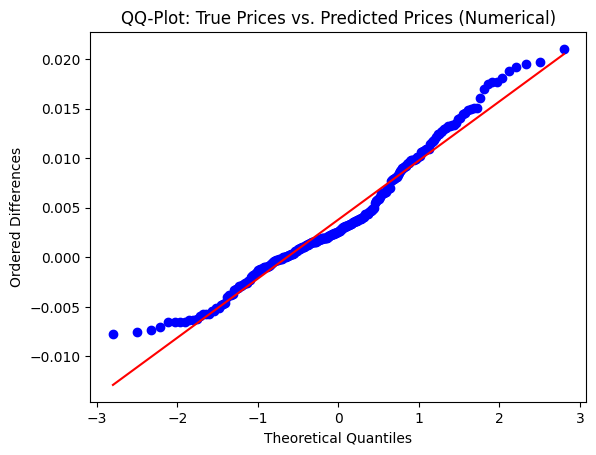

In [58]:
from scipy import stats
plt.figure()
stats.probplot(diff[1], dist="norm", plot=plt)
plt.title("QQ-Plot: True Prices vs. Predicted Prices (Numerical)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Differences")
plt.show()


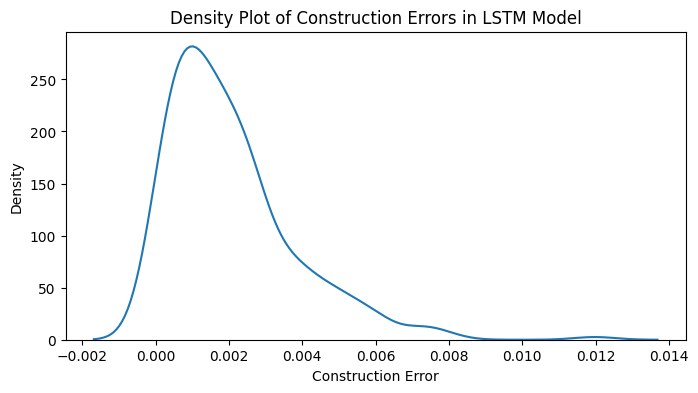

Mean of Construction Errors: 0.0020648113995823995
Standard Deviation of Construction Errors: 0.0017433694952719947


In [59]:
import seaborn as sns
# Calculate the construction errors
errors = np.abs(predictions.flatten() - y_test_transform)
plt.figure(figsize=(8, 4))
sns.kdeplot(errors, bw_adjust=1)
plt.xlabel("Construction Error")
plt.ylabel("Density")
plt.title("Density Plot of Construction Errors in LSTM Model")
plt.show()


mean_error = np.mean(errors)
std_error = np.std(errors)

print("Mean of Construction Errors:", mean_error)
print("Standard Deviation of Construction Errors:", std_error)

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
custom_objects = {"Time2Vector": Time2Vector, "TransformerEncoderCausal": TransformerEncoderCausal, "CausalAttention": CausalAttention, "SingleAttention": SingleAttention, "Time2Vec": Time2Vector}
start_date = "2010-01-01"
end_date =  "2022-01-01"
window = 30 
rollingAvg = 10
causal={}
for stock_ticker in stock_tickers:
  print(stock_ticker)
  X_train, y_train, X_val, y_val, X_test, y_test, minRet, maxRet = generate_data(stock_ticker, start_date, end_date, rollingAvg=rollingAvg, window=window)
  with tf.keras.utils.custom_object_scope(custom_objects):
    stock_model = tf.keras.models.load_model(f'/content/gdrive/MyDrive/DataMiningProject/models/{stock_ticker}-model-causal.hdf5')
  predictions = stock_model.predict(X_test)*(maxRet - minRet) + minRet
  y_test_transform = y_test*(maxRet - minRet) + minRet
  diff = predictions-y_test_transform
  r2 = r2_score(y_test_transform,predictions)
  MSE = mean_squared_error(y_test_transform,predictions)
  causal[stock_ticker] = [r2, MSE]

ADBE
[*********************100%***********************]  1 of 1 completed
9/9 [==============================] - 1s 19ms/step


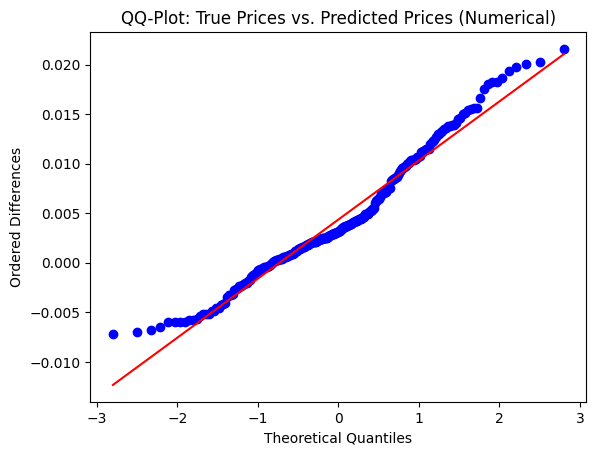

In [63]:
from scipy import stats
plt.figure()
stats.probplot(diff[1], dist="norm", plot=plt)
plt.title("QQ-Plot: True Prices vs. Predicted Prices (Numerical)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Differences")
plt.show()


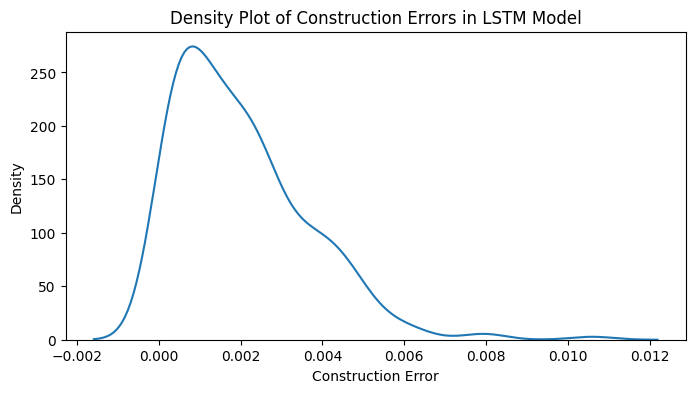

Mean of Construction Errors: 0.0020218778483588134
Standard Deviation of Construction Errors: 0.0016330094824339246


In [64]:
import seaborn as sns
# Calculate the construction errors
errors = np.abs(predictions.flatten() - y_test_transform)
plt.figure(figsize=(8, 4))
sns.kdeplot(errors, bw_adjust=1)
plt.xlabel("Construction Error")
plt.ylabel("Density")
plt.title("Density Plot of Construction Errors in LSTM Model")
plt.show()


mean_error = np.mean(errors)
std_error = np.std(errors)

print("Mean of Construction Errors:", mean_error)
print("Standard Deviation of Construction Errors:", std_error)

In [39]:
causal

{'ADBE': [0.812284343459176, 6.754710003403178e-06]}

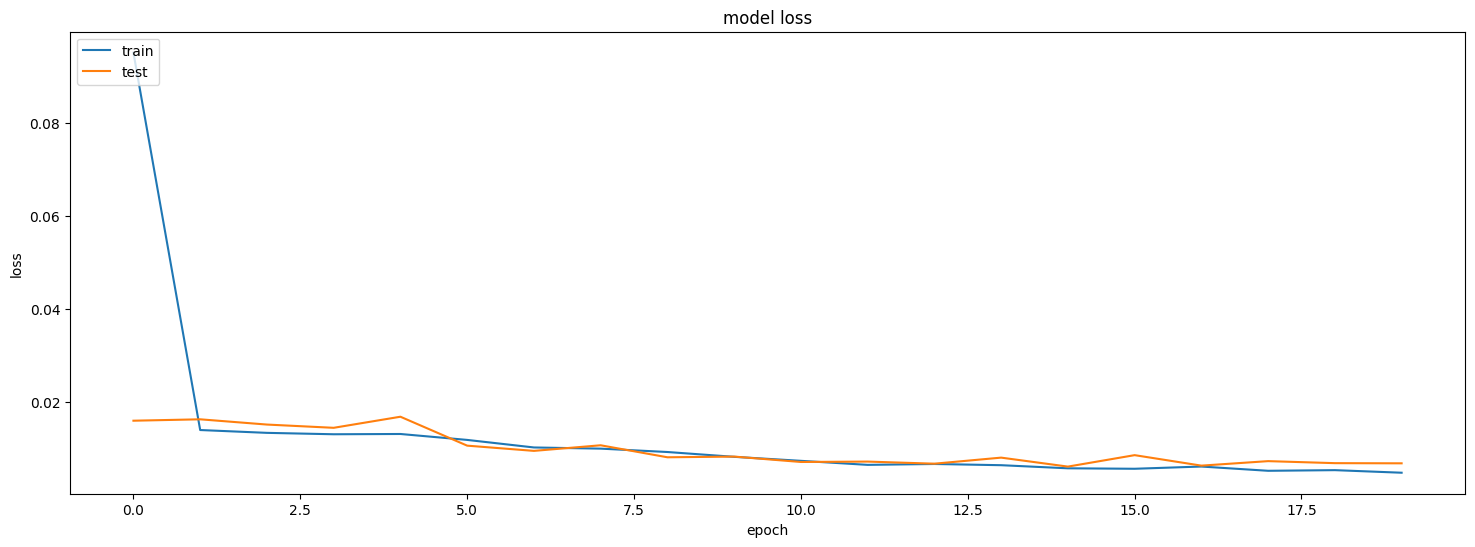

In [40]:
fig, ax = plt.subplots(figsize = (18,6))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
fig.savefig(f'/content/gdrive/MyDrive/DataMiningProject/plots/{stock_ticker}-loss-causal.png')

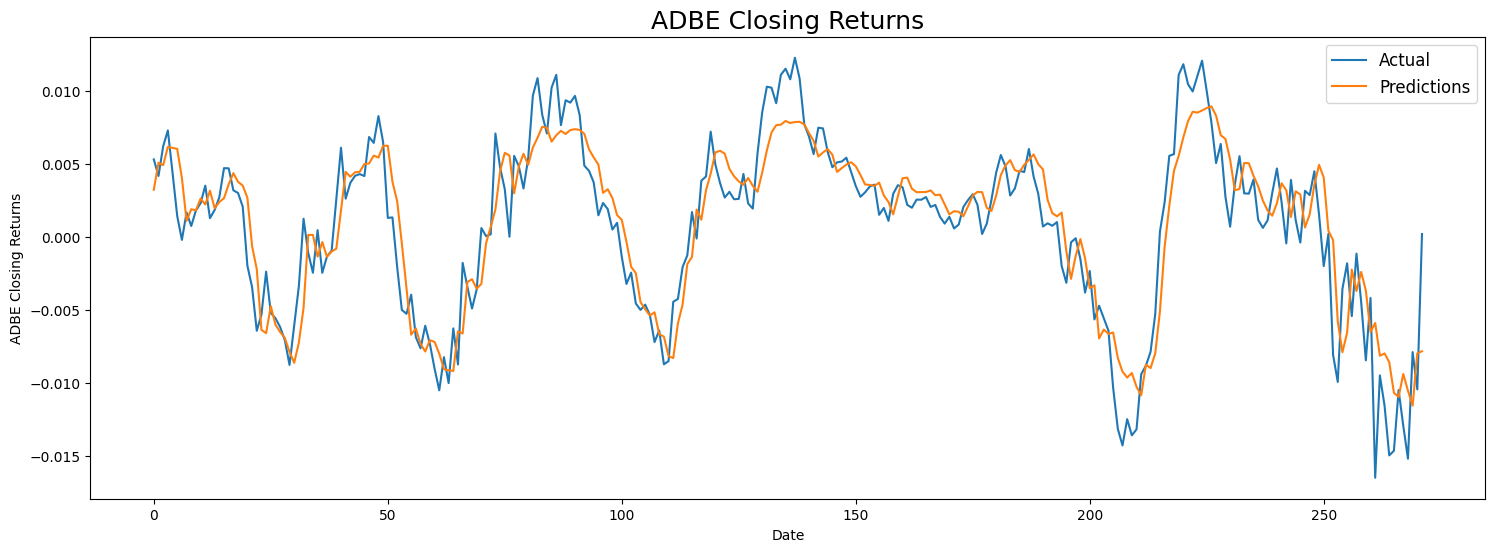

In [41]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (18,6))
ax.plot(y_test_transform, label = "Actual")
ax.plot(predictions, label = "Predictions")
ax.set_title(f'{stock_ticker} Closing Returns', fontsize=18)
ax.set_xlabel('Date')
ax.set_ylabel(f'{stock_ticker} Closing Returns')
ax.legend(loc="best", fontsize=12)
fig.savefig(f'/content/gdrive/MyDrive/DataMiningProject/plots/{stock_ticker}-plot-causal.png')

# **LSTM model Rolling Average**



In [42]:
def generate_datalstm(ticker, start_date, end_date, rollingAvg=10, window = 30):
  stock_data = yf.download(stock_ticker, interval = "1d", start=str(start_date), end=str(end_date)).drop(columns=['Adj Close'])
  stock_data[['Open', 'High', 'Low', 'Close', 'Volume']] = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(rollingAvg).mean()
  stock_data['Open'] = stock_data['Open'].pct_change()
  stock_data['High'] = stock_data['High'].pct_change()
  stock_data['Low'] = stock_data['Low'].pct_change()
  stock_data['Close'] = stock_data['Close'].pct_change()
  stock_data['Volume'] = stock_data['Volume'].pct_change()
  stock_data.dropna(how='any', axis=0, inplace=True)

  train_indexes = int(0.8*len(stock_data))
  val_indexes = int(0.1*len(stock_data))

  train_data = stock_data.iloc[:train_indexes, :]

  # minRet = train_data[['Open', 'High', 'Low', 'Close']].min(axis=0).min(axis=0)
  minRet = min(train_data[['Open', 'High', 'Low', 'Close']].min(axis=0))
  # maxRet = train_data[['Open', 'High', 'Low', 'Close']].max(axis=0).max(axis=0)
  maxRet = max(train_data[['Open', 'High', 'Low', 'Close']].max(axis=0))

  stock_data['Open'] = (stock_data['Open'] - minRet) / (maxRet - minRet)
  stock_data['High'] = (stock_data['High'] - minRet) / (maxRet - minRet)
  stock_data['Low'] = (stock_data['Low'] - minRet) / (maxRet - minRet)
  stock_data['Close'] = (stock_data['Close'] - minRet) / (maxRet - minRet)

  minVolume = min(train_data[['Volume']].min(axis=0))
  maxVolume = max(train_data[['Volume']].max(axis=0))

  stock_data['Volume'] = (stock_data['Volume'] - minVolume) / (maxVolume - minVolume)

  train_data = stock_data.iloc[:train_indexes, :]
  val_data = stock_data.iloc[train_indexes:train_indexes+val_indexes, :]
  test_data = stock_data.iloc[train_indexes+val_indexes:, :]

  X_train,y_train = [], []
  for i in range(window, len(train_data)):
    X_train.append(train_data.values[i-window:i])
    y_train.append(train_data.values[:, 3][i])
  X_train, y_train = np.array(X_train), np.array(y_train)

  X_val, y_val = [], []
  for i in range(window, len(val_data)):
      X_val.append(val_data.values[i-window:i])
      y_val.append(val_data.values[:, 3][i])
  X_val, y_val = np.array(X_val), np.array(y_val)

  X_test, y_test = [], []
  for i in range(window, len(test_data)):
      X_test.append(test_data.values[i-window:i])
      y_test.append(test_data.values[:, 3][i])    
  X_test, y_test = np.array(X_test), np.array(y_test)

  return X_train, y_train, X_val, y_val, X_test, y_test, minRet, maxRet

In [43]:
stock_tickers

['ADBE']

In [50]:
#Train an LSTM for each stock based on the 60-day price history of all other SP500 stocks
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.models import Sequential

patience = 3

callback = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

j = 0

start_date = "2010-01-01"
end_date =  "2022-01-01"
window = 30
stock_tickers_LSTM = ['ADBE']

for stock_ticker in stock_tickers_LSTM:
    print(stock_ticker)
    X_train, y_train, X_val, y_val, X_test, y_test, minRet, maxRet = generate_datalstm(stock_ticker, start_date, end_date)

    lstm = Sequential()
    lstm.add(LSTM(70, return_sequences=True, input_shape=(window,X_train.shape[2])))
    lstm.add(LSTM(30, return_sequences=False))
    lstm.add(Dense(1, activation = 'linear'))


    lstm.compile(loss='mean_squared_error', optimizer='adam')
    history = lstm.fit(X_train, y_train, batch_size=32, epochs= 30, validation_data=(X_val, y_val), callbacks=[callback])

    lstm.save("/content/gdrive/MyDrive/DataMiningProject/models/" + stock_ticker)
    print("Iteration: ", j)
    j += 1

ADBE
[*********************100%***********************]  1 of 1 completed
Epoch 1/30
75/75 [==============================] - 13s 82ms/step - loss: 0.0209 - val_loss: 0.0115
Epoch 2/30
75/75 [==============================] - 3s 42ms/step - loss: 0.0086 - val_loss: 0.0097
Epoch 3/30
75/75 [==============================] - 3s 42ms/step - loss: 0.0068 - val_loss: 0.0079
Epoch 4/30
75/75 [==============================] - 3s 46ms/step - loss: 0.0050 - val_loss: 0.0086
Epoch 5/30
75/75 [==============================] - 5s 65ms/step - loss: 0.0043 - val_loss: 0.0064
Epoch 6/30
75/75 [==============================] - 3s 41ms/step - loss: 0.0042 - val_loss: 0.0061
Epoch 7/30
75/75 [==============================] - 3s 43ms/step - loss: 0.0034 - val_loss: 0.0062
Epoch 8/30
75/75 [==============================] - 3s 43ms/step - loss: 0.0035 - val_loss: 0.0060
Epoch 9/30
75/75 [==============================] - 5s 69ms/step - loss: 0.0035 - val_loss: 0.0068
Epoch 10/30
75/75 [===============

Iteration:  0


9/9 [==============================] - 0s 25ms/step


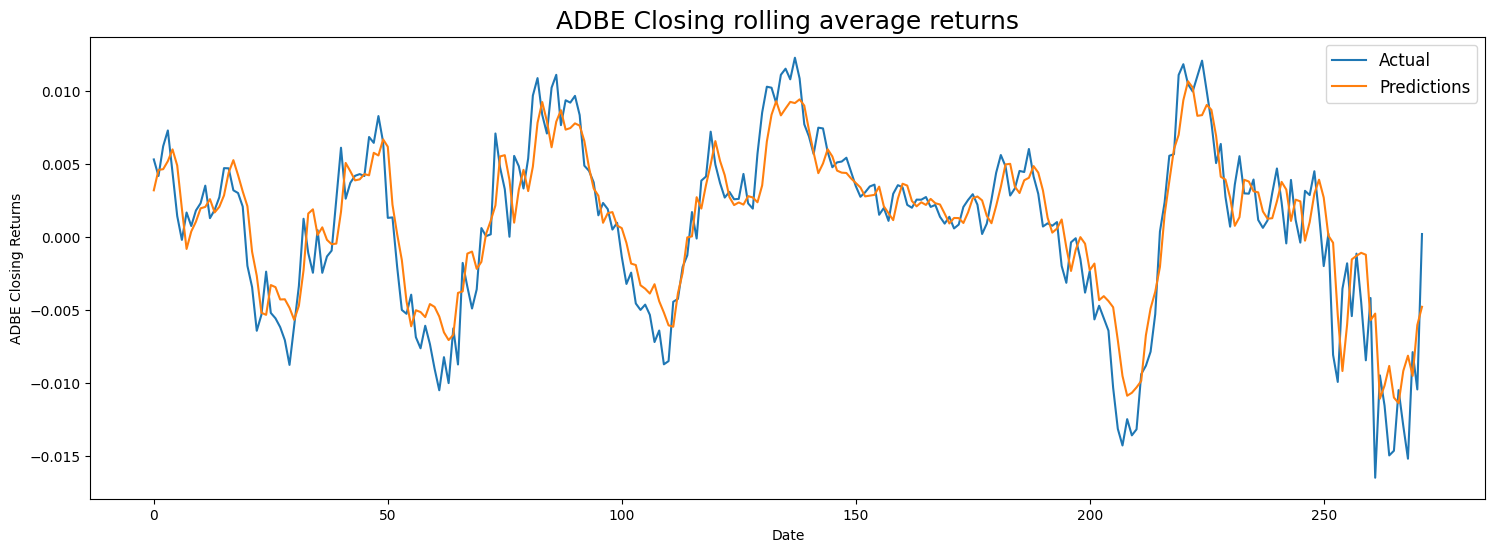

In [67]:
import matplotlib.pyplot as plt

predictions = lstm.predict(X_test)*(maxRet - minRet) + minRet
y_test_transform = y_test*(maxRet - minRet) + minRet
prediction_stocks[stock_ticker] = [predictions, y_test_transform]
    
fig, ax = plt.subplots(figsize = (18,6))
ax.plot(y_test_transform, label = "Actual")
ax.plot(predictions, label = "Predictions")
ax.set_title(f'{stock_ticker} Closing rolling average returns', fontsize=18)
ax.set_xlabel('Date')
ax.set_ylabel(f'{stock_ticker} Closing Returns')
ax.legend(loc="best", fontsize=12)
fig.savefig(f'/content/gdrive/MyDrive/DataMiningProject/plots/{stock_ticker}-plot-lstm200.png')

In [68]:
from sklearn.metrics import mean_squared_error,r2_score

mse = mean_squared_error(y_test_transform, predictions, squared=True)
r2 = r2_score(y_test_transform, predictions)
print("RMSE:", mse)
print('R2',r2)

RMSE: 6.247236051344363e-06
R2 0.8263872147948946


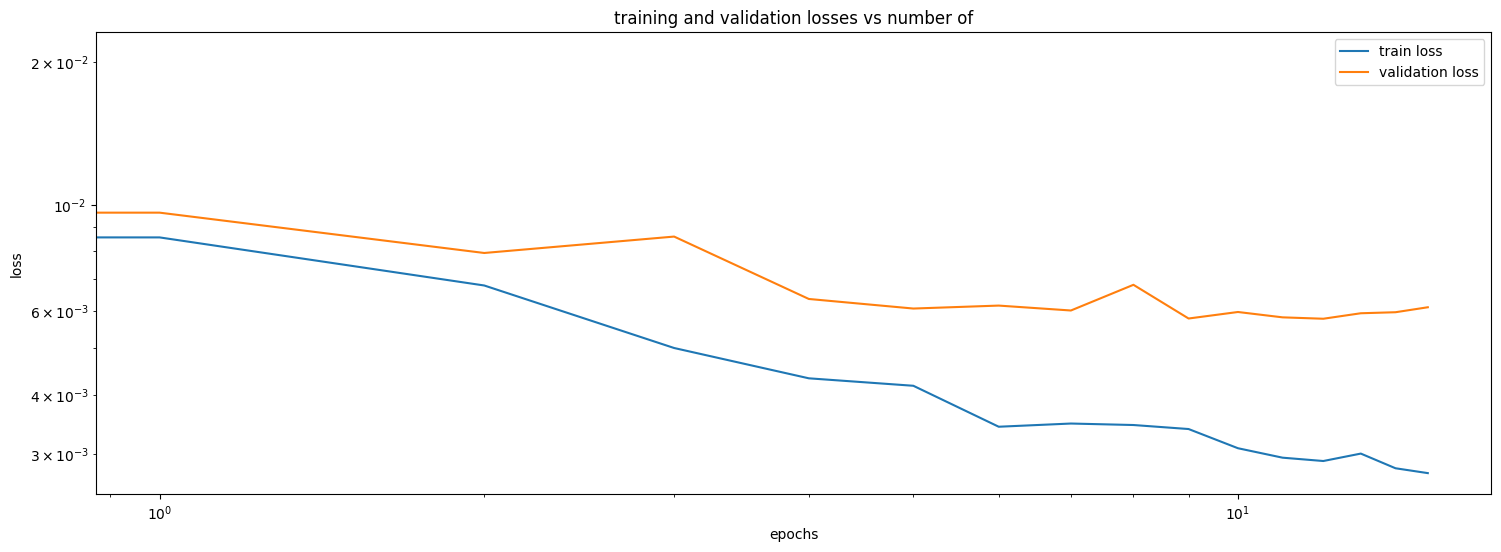

In [70]:
# Displaying train vs validation loss over each epoch

plt.figure(figsize=(18, 6))
hist = pd.DataFrame(history.history)
plt.loglog(hist.index,hist["loss"],label='train loss')
plt.loglog(hist.index,hist["val_loss"],label='validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('training and validation losses vs number of')
plt.legend()
plt.show()
fig.savefig(f'/content/gdrive/MyDrive/DataMiningProject/plots/{stock_ticker}-loss-lstm200.png')

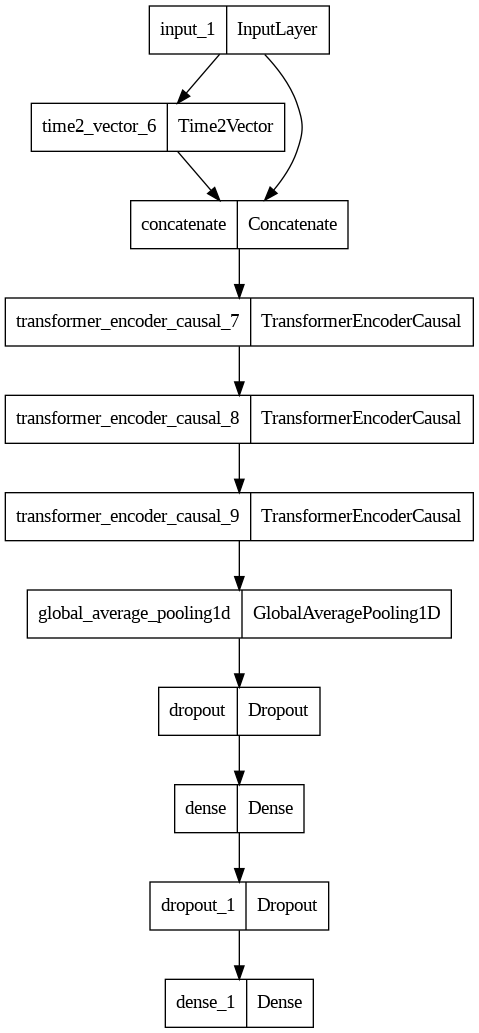

In [75]:
from tensorflow.keras.utils import plot_model
plot_model(stock_model, to_file='/content/gdrive/MyDrive/DataMiningProject/stock_model.png')

In [76]:
from scipy import stats

predictions = lstm.predict(X_test)*(maxRet - minRet) + minRet
y_test_transform = y_test*(maxRet - minRet) + minRet
prediction_stocks[stock_ticker] = [predictions, y_test_transform]
    

true_z_scores = stats.zscore(y_test_transform)

predicted_z_scores = stats.zscore(predictions)


9/9 [==============================] - 0s 30ms/step


In [77]:
x = true_z_scores - predicted_z_scores

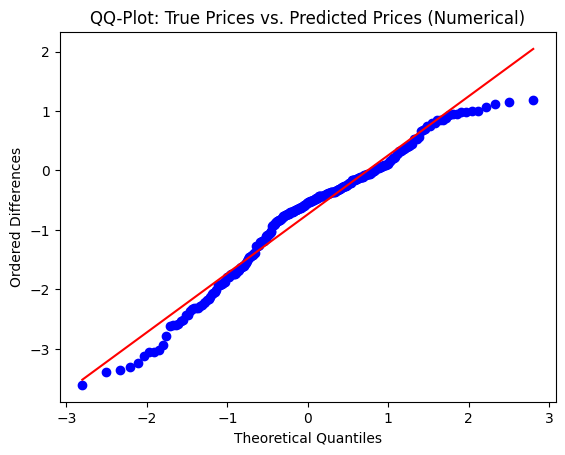

In [78]:
plt.figure()
stats.probplot(x[1], dist="norm", plot=plt)
plt.title("QQ-Plot: True Prices vs. Predicted Prices (Numerical)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Differences")
plt.show()


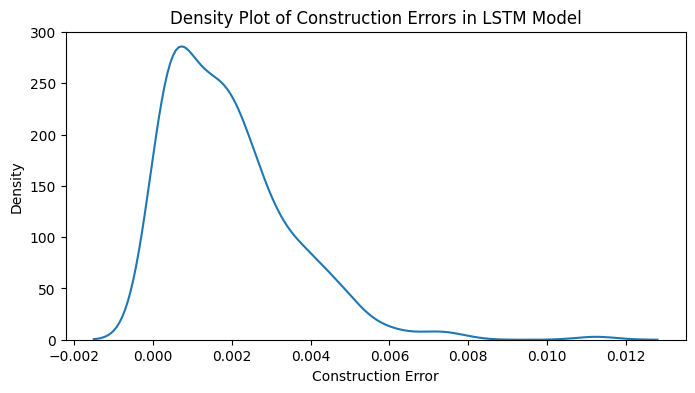

Mean of Construction Errors: 0.0019286961418902742
Standard Deviation of Construction Errors: 0.0015897695567603292


In [79]:
import seaborn as sns
# Calculate the construction errors
errors = np.abs(predictions.flatten() - y_test_transform)
plt.figure(figsize=(8, 4))
sns.kdeplot(errors, bw_adjust=1)
plt.xlabel("Construction Error")
plt.ylabel("Density")
plt.title("Density Plot of Construction Errors in LSTM Model")
plt.show()


mean_error = np.mean(errors)
std_error = np.std(errors)

print("Mean of Construction Errors:", mean_error)
print("Standard Deviation of Construction Errors:", std_error)

# No rolling average LSTM

In [92]:
#Train an LSTM for each stock based on the 60-day price history of all other SP500 stocks
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.models import Sequential

patience = 5

callback = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

j = 0

start_date = "2010-01-01"
end_date =  "2022-01-01"
window = 60
stock_tickers_LSTM = ['ADBE']

for stock_ticker in stock_tickers_LSTM:
    print(stock_ticker)
    X_train, y_train, X_val, y_val, X_test, y_test, minRet, maxRet = generate_datalstm(stock_ticker, start_date, end_date, rollingAvg=1, window = window)


    lstm1 = Sequential()
    lstm1.add(LSTM(200, return_sequences=True, input_shape=(window,X_train.shape[2])))
    lstm1.add(LSTM(100, return_sequences=False))
    lstm1.add(Dense(1))


    lstm1.compile(loss='mean_squared_error', optimizer='adam')
    history1 = lstm1.fit(X_train, y_train, batch_size=128, epochs= 150, validation_data=(X_val, y_val), callbacks=[callback])

    lstm1.save(f"/content/gdrive/MyDrive/DataMiningProject/models/{stock_ticker}.hdf5")
    print("Iteration: ", j)
    j += 1

ADBE
[*********************100%***********************]  1 of 1 completed
Epoch 1/150
19/19 [==============================] - 20s 749ms/step - loss: 0.0373 - val_loss: 0.0063
Epoch 2/150
19/19 [==============================] - 10s 511ms/step - loss: 0.0034 - val_loss: 0.0068
Epoch 3/150
19/19 [==============================] - 11s 580ms/step - loss: 0.0025 - val_loss: 0.0064
Epoch 4/150
19/19 [==============================] - 11s 609ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 5/150
19/19 [==============================] - 11s 610ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 6/150
19/19 [==============================] - 10s 507ms/step - loss: 0.0024 - val_loss: 0.0064
Epoch 7/150
19/19 [==============================] - 12s 626ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 8/150
19/19 [==============================] - 13s 702ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 9/150
19/19 [==============================] - 11s 606ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 10

8/8 [==============================] - 2s 77ms/step


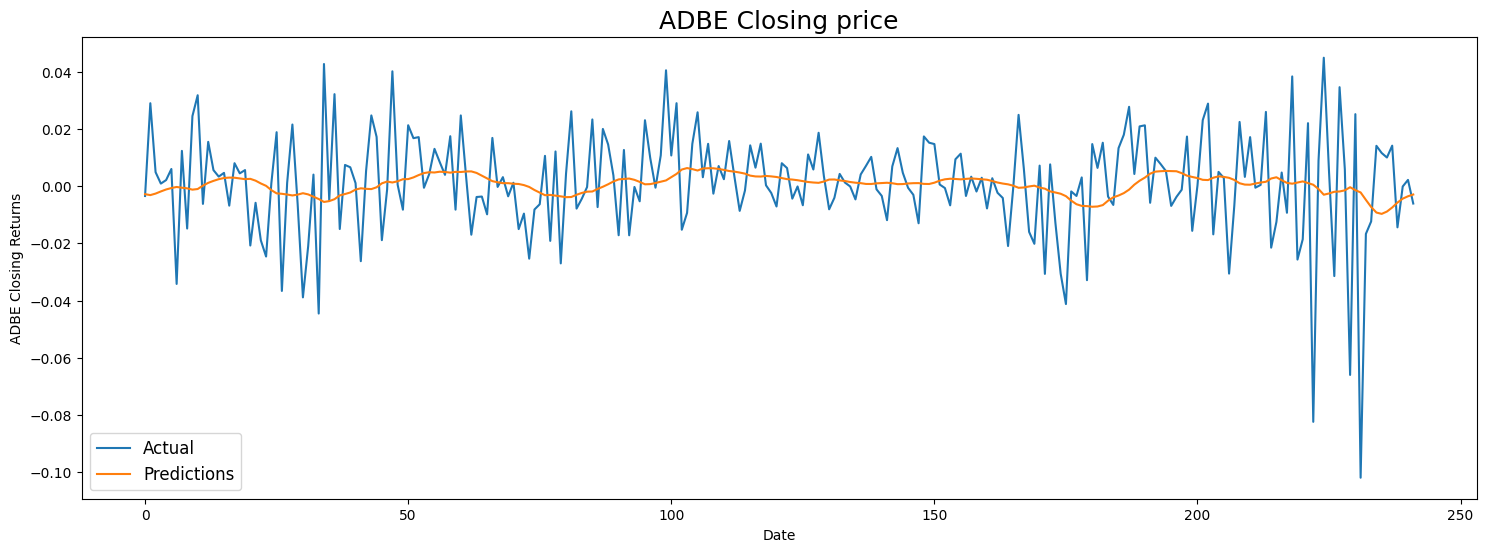

In [87]:
import matplotlib.pyplot as plt

predictions = lstm1.predict(X_test)*(maxRet - minRet) + minRet
y_test_transform = y_test*(maxRet - minRet) + minRet
prediction_stocks[stock_ticker] = [predictions, y_test_transform]
    
fig, ax = plt.subplots(figsize = (18,6))
ax.plot(y_test_transform, label = "Actual")
ax.plot(predictions, label = "Predictions")
ax.set_title(f'{stock_ticker} Closing price', fontsize=18)
ax.set_xlabel('Date')
ax.set_ylabel(f'{stock_ticker} Closing Returns')
ax.legend(loc="best", fontsize=12)

In [88]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_transform, predictions, squared=False)

print("RMSE:", mse)

RMSE: 0.018429327094261715


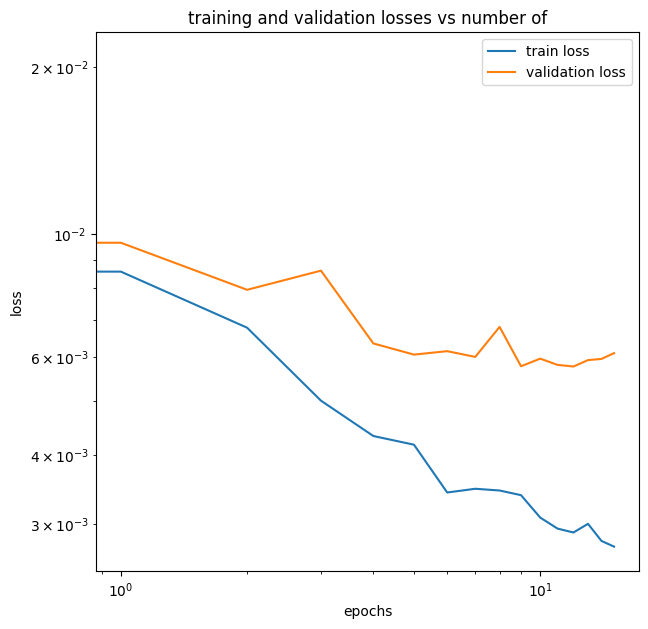

In [89]:
# Displaying train vs validation loss over each epoch

plt.figure(figsize=(7, 7))
hist = pd.DataFrame(history.history)
plt.loglog(hist.index,hist["loss"],label='train loss')
plt.loglog(hist.index,hist["val_loss"],label='validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('training and validation losses vs number of')
plt.legend()
plt.show()

##Index forecasting by biggest companies stocks prediction

In [93]:
import statsmodels.formula.api as smf
import pandas as pd

df_stock = pd.read_csv('/content/gdrive/MyDrive/DataMiningProject/sp500_stocks_df_clean.csv').set_index('Date').rename(columns = {'BRK-B':'BRK', 'BF-B':'BF'})
df_index = pd.read_csv('/content/gdrive/MyDrive/DataMiningProject/sp500_index_df_clean.csv')
df_stock['SNP'] = df_index['Normalized_Returns'].to_numpy()
tickers = list(df_stock.columns)
tickers.remove('SNP')
formula = "SNP ~"
for ticker in tickers:
  formula+= ' + '+ticker
mod = smf.ols(formula=formula, data=df_stock)
res = mod.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SNP   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     810.8
Date:                Wed, 03 May 2023   Prob (F-statistic):               0.00
Time:                        00:29:51   Log-Likelihood:                 2469.2
No. Observations:                1964   AIC:                            -4012.
Df Residuals:                    1501   BIC:                            -1428.
Df Model:                         462                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0068      0.002     -3.837      0.000      -0.010      -0.003
A             -0.0007      0.004     -0.180      0.857      -0.009       0.007
AAL            0.0018      0.005      0.362      0.717      -0.008       0.011
AAP            0.0075      0.003      2.392      0.017       0.001       0.014
AAPL           0.0885      0.004     25.168      0.000       0.082       0.095
ABBV           0.0065      0.003      2.354      0.019       0.001       0.012
ABC            0.0021      0.004      0.558      0.577      -0.005       0.009
ABMD          -0.0056      0.003     -2.143      0.032      -0.011      -0.000
ABT            0.0090      0.004      2.363      0.018       0.002       0.017
ACGL          -0.0064      0.004     -1.491      0.136      -0.015       0.002
ACN            0.0094      0.004      2.302      0.021       0.001       0.017
ADBE           0.0226      0.004      5.402      0.000       0.014       0.031
ADI           -0.0028      0.005     -0.615      0.539      -0.012       0.006
ADM            0.0073      0.003      2.302      0.021       0.001       0.014
ADP            0.0014      0.004      0.341      0.733      -0.007       0.010
ADSK           0.0023      0.003      0.684      0.494      -0.004       0.009
AEE            0.0061      0.006      1.068      0.286      -0.005       0.017
AEP            0.0054      0.006      0.966      0.334      -0.006       0.016
AES           -0.0025      0.003     -0.755      0.450      -0.009       0.004
AFL           -0.0038      0.005     -0.803      0.422      -0.013       0.005
AIG            0.0010      0.005      0.228      0.820      -0.008       0.010
AIZ            0.0070      0.003      2.153      0.031       0.001       0.013
AJG            0.0046      0.005      0.966      0.334      -0.005       0.014
AKAM           0.0007      0.003      0.251      0.802      -0.005       0.006
ALB            0.0077      0.003      2.578      0.010       0.002       0.014
ALGN          -0.0060      0.003     -1.936      0.053      -0.012    8.06e-05
ALK            0.0020      0.004      0.475      0.635      -0.006       0.010
ALL            0.0076      0.004      2.014      0.044       0.000       0.015
ALLE          -0.0023      0.003     -0.671      0.502      -0.009       0.004
AMAT           0.0061      0.005      1.243      0.214      -0.004       0.016
AMCR           0.0015      0.003      0.564      0.573      -0.004       0.007
AMD            0.0066      0.003      2.506      0.012       0.001       0.012
AME           -0.0024      0.005     -0.486      0.627      -0.012       0.007
AMGN           0.0193      0.003      5.757      0.000       0.013       0.026
AMP            0.0027      0.006      0.479      0.632      -0.008       0.014
AMT            0.0037      0.004      0.830      0.407      -0.005       0.012
AM

Text(0.5, 1.0, '')

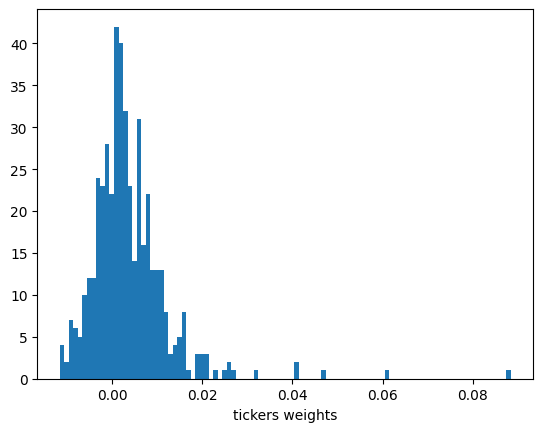

In [94]:
plt.hist(res.params, bins=100)
plt.xlabel("tickers weights")
plt.title('')

In [95]:
big20_tickers = res.params.sort_values(ascending = False)[:20]
print(big20_tickers)
big20  = list(big20_tickers.index)
print(big20)

AAPL     0.088506
MSFT     0.060639
GOOG     0.046428
META     0.040931
AMZN     0.040866
BAC      0.031745
BRK      0.027084
MA       0.026035
UNH      0.025479
XOM      0.024707
ADBE     0.022649
TFC      0.020798
QCOM     0.020594
NVDA     0.020413
DIS      0.020192
BA       0.019619
CMCSA    0.019448
AMGN     0.019261
TMO      0.018626
NEE      0.018505
dtype: float64
['AAPL', 'MSFT', 'GOOG', 'META', 'AMZN', 'BAC', 'BRK', 'MA', 'UNH', 'XOM', 'ADBE', 'TFC', 'QCOM', 'NVDA', 'DIS', 'BA', 'CMCSA', 'AMGN', 'TMO', 'NEE']


In [96]:
def generate_stocks(ticker, start_date, end_date, MA = 10):
  stock_data = yf.download(stock_ticker, interval = "1d", start=str(start_date), end=str(end_date))[['Close']].rolling(MA).mean()
  stock_data['Close'] = stock_data['Close'].pct_change()
  stock_data.dropna(how='any', axis=0, inplace=True)

  return stock_data['Close'].to_numpy()

In [97]:
import statsmodels.formula.api as smf
import pandas as pd


start_date = "2015-01-01"
end_date =  "2022-01-01"

big20 = ['AAPL', 'MSFT', 'GOOG', 'META', 'AMZN', 'BAC', 'MA', 'UNH', 'XOM', 'ADBE', 'TFC', 'QCOM', 'NVDA', 'DIS', 'BA', 'CMCSA', 'AMGN', 'TMO', 'NEE']
df_stock = pd.DataFrame()
for stock_ticker in big20:
  df_stock[stock_ticker] = generate_stocks(stock_ticker, start_date, end_date)

index = yf.download('^GSPC', interval = "1d", start=str(start_date), end=str(end_date))['Close'].rolling(10).mean().pct_change()
index.dropna(how='any', axis=0, inplace=True)
df_stock['SNP'] = index.to_numpy()
formula = "SNP ~"
for ticker in big20:
  formula+= ' + '+ticker
mod = smf.ols(formula=formula, data=df_stock[big20+['SNP']])
res = mod.fit()
res.summary()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SNP   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     2224.
Date:                Wed, 03 May 2023   Prob (F-statistic):               0.00
Time:                        00:30:01   Log-Likelihood:                 10450.
No. Observations:                1753   AIC:                        -2.086e+04
Df Residuals:                    1733   BIC:                        -2.075e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0002   1.64e-05     -9.798      0.000      -0.000      -0.000
AAPL           0.0598      0.004     15.227      0.000       0.052       0.067
MSFT           0.0802      0.006     13.399      0.000       0.068       0.092
GOOG           0.0323      0.005      6.201      0.000       0.022       0.043
META           0.0261      0.004      6.664      0.000       0.018       0.034
AMZN           0.0172      0.004      4.433      0.000       0.010       0.025
BAC            0.0578      0.005     11.203      0.000       0.048       0.068
MA             0.0439      0.005      8.435      0.000       0.034       0.054
UNH            0.0710      0.004     16.584      0.000       0.063       0.079
XOM            0.0832      0.004     20.338      0.000       0.075       0.091
ADBE           0.0237      0.005      4.794      0.000       0.014       0.033
TFC            0.0514      0.005      9.457      0.000       0.041       0.062
QCOM           0.0175      0.003      6.830      0.000       0.012       0.023
NVDA           0.0263      0.002     11.138      0.000       0.022       0.031
DIS            0.0338      0.005      7.306      0.000       0.025       0.043
BA             0.0288      0.003     10.506      0.000       0.023       0.034
CMCSA          0.0694      0.005     14.748      0.000       0.060       0.079
AMGN           0.0505      0.004     12.558      0.000       0.043       0.058
TMO            0.0704      0.005     13.891      0.000       0.060       0.080
NEE            0.0877      0.005     18.658      0.000       0.079       0.097
==============================================================================
Omnibus:                       12.127   Durbin-Watson:                   0.238
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.319
Skew:                          -0.204   Prob(JB):                      0.00211
Kurtosis:                       2.957   Cond. No.                         490.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Index Prediction with Causal masking

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[*********************100%***********************]  1 of 1 completed


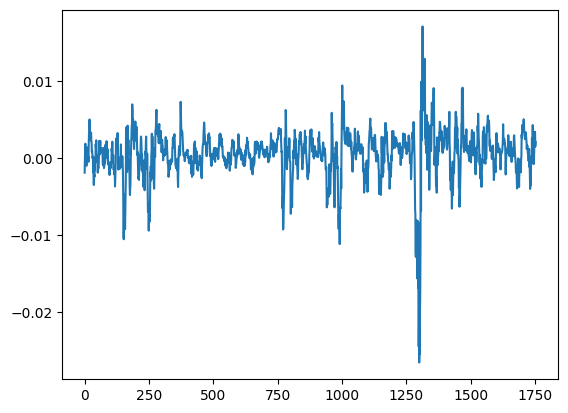

[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 1s 21ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 1s 20ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 1s 19ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 2s 34ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 1s 22ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 1s 22ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 1s 20ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 1s 21ms/step
[*********************100%******

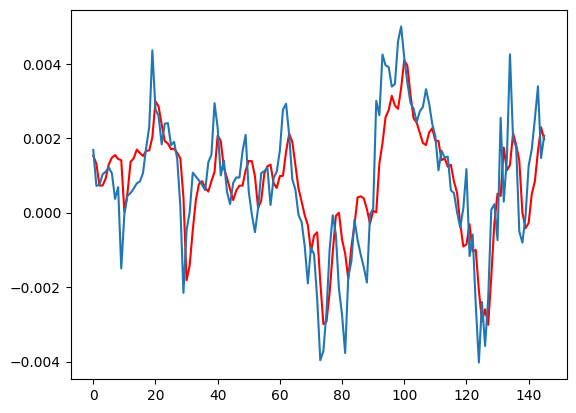

In [112]:
import tensorflow as tf 

from google.colab import drive, files
drive.mount('/content/gdrive')

start_date = "2015-01-01"
end_date =  "2022-01-01"

custom_objects = {"Time2Vec": Time2Vector, "Time2Vector": Time2Vector, "TransformerEncoderCausal": TransformerEncoderCausal, "CausalAttention": CausalAttention, "SingleAttention": SingleAttention}

tickers = ['AAPL','MSFT','GOOG','META','AMZN','BAC','MA','UNH','XOM','ADBE','TFC','QCOM','NVDA','DIS','BA','CMCSA','AMGN','TMO','NEE']
n = len(tickers)
index = yf.download('^GSPC', interval = "1d", start=str(start_date), end=str(end_date))['Close'].rolling(10).mean().pct_change()
index.dropna(how='any', axis=0, inplace=True)
index = index.to_numpy()
plt.plot(index)
plt.show()
stock_train_pred = pd.DataFrame()
stock_test_pred = pd.DataFrame()
for stock_ticker in tickers:
  with tf.keras.utils.custom_object_scope(custom_objects):
    stock_model = tf.keras.models.load_model(f'/content/gdrive/MyDrive/DataMiningProject/models/{stock_ticker}-model-causal.hdf5')
  X_train, y_train, X_val, y_val, X_test, y_test, minRet, maxRet = generate_data(stock_ticker, start_date = start_date, end_date = end_date)
  stock_test_pred[stock_ticker] = np.array(stock_model.predict(X_test).flatten())*(maxRet -minRet)+minRet

index_test_pred = res.predict(stock_test_pred).to_numpy()
index_test = index[-len(index_test_pred):]
plt.plot(index_test_pred, color='r')
plt.plot(index_test)
plt.show()

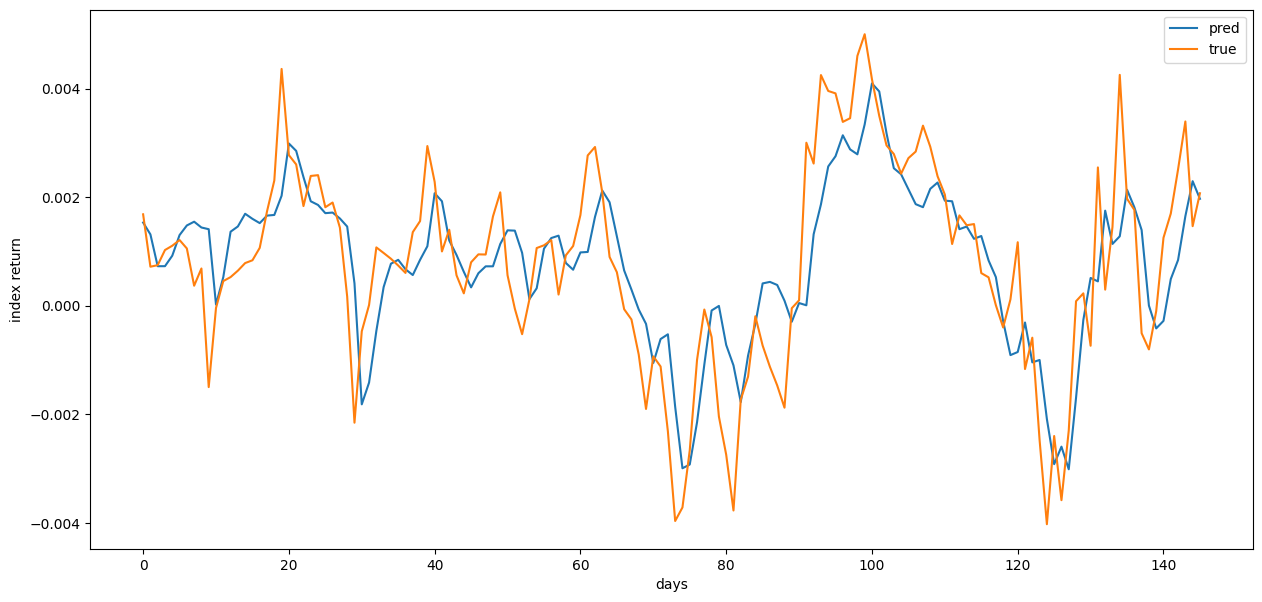

In [115]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(index_test_pred, label='pred')
ax.plot(index_test, label='true')
ax.set_ylabel('index return')
ax.set_xlabel('days')
ax.legend()

In [120]:
print('rmse :', mean_squared_error(index_test_pred, index_test, squared = False))

rmse : 0.0011107343124371596


Index Prediction with MultiHead Attention

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[*********************100%***********************]  1 of 1 completed


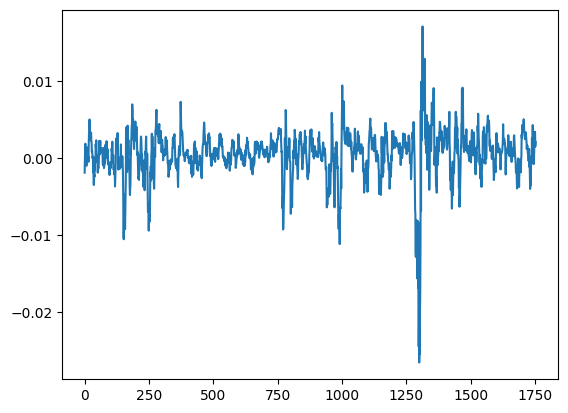

[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 14s 157ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 7s 149ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 7s 148ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 10s 261ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 8s 144ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 8s 146ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 8s 143ms/step
[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 8s 149ms/step
[*********************

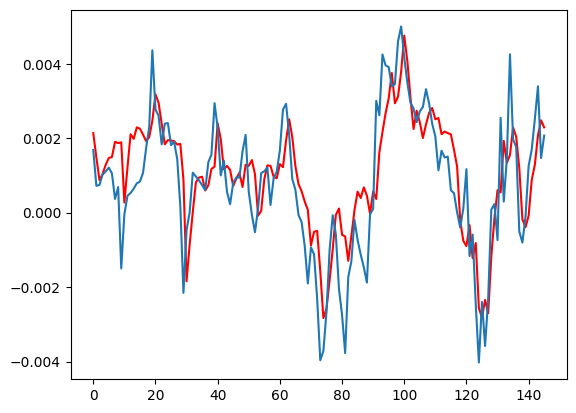

In [121]:
import tensorflow as tf 

start_date = "2015-01-01"
end_date =  "2022-01-01"

custom_objects = {"Time2Vector": Time2Vector, "TransformerEncoder": TransformerMultiHeadEncoder, "MultiAttention": MultiAttention, "SingleAttention": SingleAttention2}

tickers = ['AAPL','MSFT','GOOG','META','AMZN','BAC','MA','UNH','XOM','ADBE','TFC','QCOM','NVDA','DIS','BA','CMCSA','AMGN','TMO','NEE']
n = len(tickers)
index = yf.download('^GSPC', interval = "1d", start=str(start_date), end=str(end_date))['Close'].rolling(10).mean().pct_change()
index.dropna(how='any', axis=0, inplace=True)
index = index.to_numpy()
plt.plot(index)
plt.show()
stock_train_pred = pd.DataFrame()
stock_test_pred = pd.DataFrame()
for stock_ticker in tickers:
  with tf.keras.utils.custom_object_scope(custom_objects):
    stock_model = tf.keras.models.load_model(f'/content/gdrive/MyDrive/DataMiningProject/models/{stock_ticker}-model.hdf5')
  X_train, y_train, X_val, y_val, X_test, y_test, minRet, maxRet = generate_data(stock_ticker, start_date = start_date, end_date = end_date)
  stock_test_pred[stock_ticker] = np.array(stock_model.predict(X_test).flatten())*(maxRet -minRet)+minRet

index_test_pred = res.predict(stock_test_pred).to_numpy()
index_test = index[-len(index_test_pred):]
plt.plot(index_test_pred, color='r')
plt.plot(index_test)
plt.show()

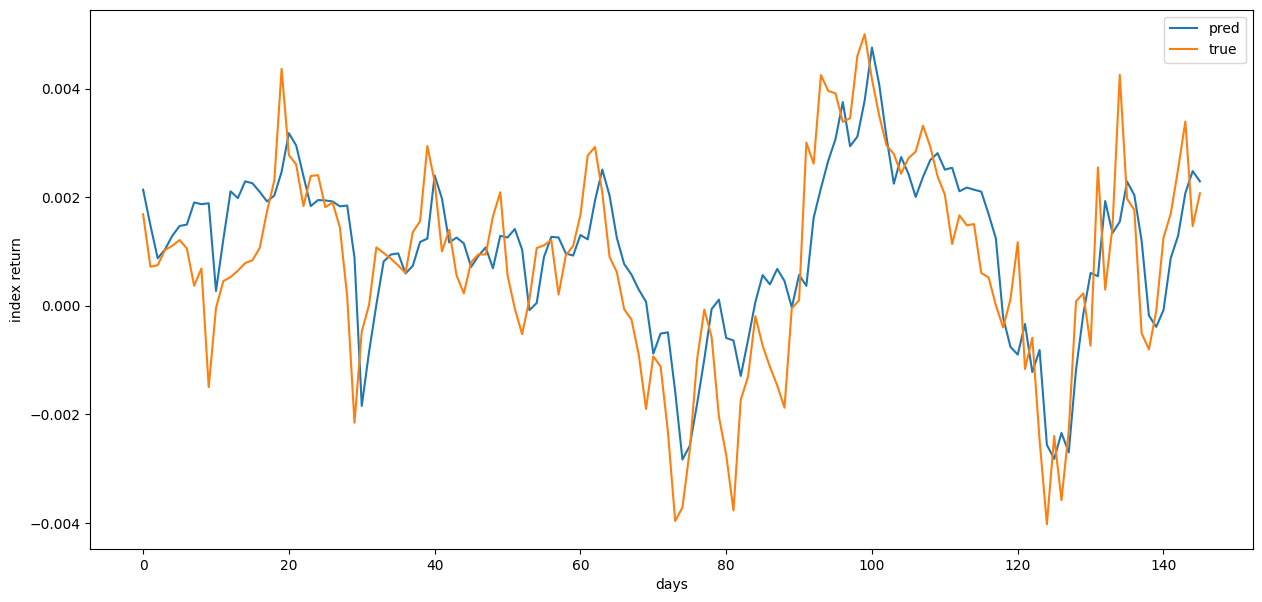

In [124]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(index_test_pred, label='pred')
ax.plot(index_test, label='true')
ax.set_ylabel('index return')
ax.set_xlabel('days')
ax.legend()


In [125]:
print('rmse :', mean_squared_error(index_test_pred, index_test, squared = False))

rmse : 0.00114398514566564
